# Лабораторная работа №6 (Проведение исследований с моделями классификации)

## 1.	Выбор начальных условий

В качестве датасета был выбран https://www.kaggle.com/datasets/mdsagorahmed/fruit-image-dataset-22-classes, представляющий собой набор из фотографий фруктов из 22 классов (11 видов фруктов и две вариации на каждый - спелый и неспелый).

Модель, обученную на этом датасете, можно использовать в автоматизации сортировки на продуктовых предприятиях

In [ ]:
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets, transforms, models
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import seaborn as sns
import os
from tqdm import tqdm

In [ ]:
import kagglehub

data_dir = kagglehub.dataset_download("mdsagorahmed/fruit-image-dataset-22-classes")

print("Path to dataset files:", data_dir)

100%|██████████| 39.0M/39.0M [00:01<00:00, 26.2MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/mdsagorahmed/fruit-image-dataset-22-classes/versions/1


In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

dataset = datasets.ImageFolder(data_dir + '/Ripe & Unripe Fruits', transform=transform)

In [ ]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

batch_size = 32
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

Посмотрим случайные картинки из датасета, чтобы понять, с чем придется работать

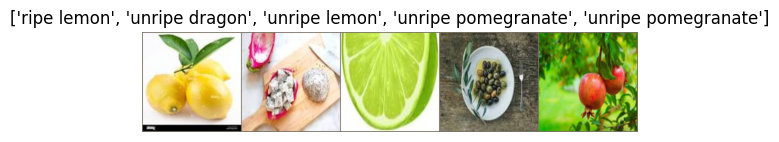

In [ ]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.axis('off')


inputs, classes = next(iter(train_loader))

out = torchvision.utils.make_grid(inputs[:5])
imshow(out, title=[dataset.classes[x] for x in classes[:5]])
plt.show()

## 2.	Создание бейзлайна и оценка качества

Инициализируем используемые модели. В данной работе будут использоваться модели ResNet-18 и ViT-B/16

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_resnet = models.resnet18(pretrained=True)
num_ftrs = model_resnet.fc.in_features
model_resnet.fc = torch.nn.Linear(num_ftrs, len(dataset.classes))
model_resnet = model_resnet.to(device)

model_vit = models.vit_b_16(pretrained=True)
model_vit.heads.head = torch.nn.Linear(model_vit.heads.head.in_features, len(dataset.classes))
model_vit = model_vit.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 193MB/s]
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed i

Функция обучения модели:

In [ ]:
def train_model(model, criterion, optimizer, num_epochs=5):
    losses = []
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in tqdm(train_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)
        losses.append(epoch_loss)
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')

    return losses

Обучим модель ResNet-18:

In [ ]:
criterion = torch.nn.CrossEntropyLoss()
optimizer_resnet = torch.optim.Adam(model_resnet.parameters(), lr=1e-3)
losses_resnet = train_model(model_resnet, criterion, optimizer_resnet)

100%|██████████| 218/218 [00:35<00:00,  6.15it/s]


Epoch 1/5, Loss: 2.0489


100%|██████████| 218/218 [00:33<00:00,  6.53it/s]


Epoch 2/5, Loss: 1.4834


100%|██████████| 218/218 [00:33<00:00,  6.58it/s]


Epoch 3/5, Loss: 1.1947


100%|██████████| 218/218 [00:33<00:00,  6.54it/s]


Epoch 4/5, Loss: 0.9612


100%|██████████| 218/218 [00:33<00:00,  6.57it/s]

Epoch 5/5, Loss: 0.7549


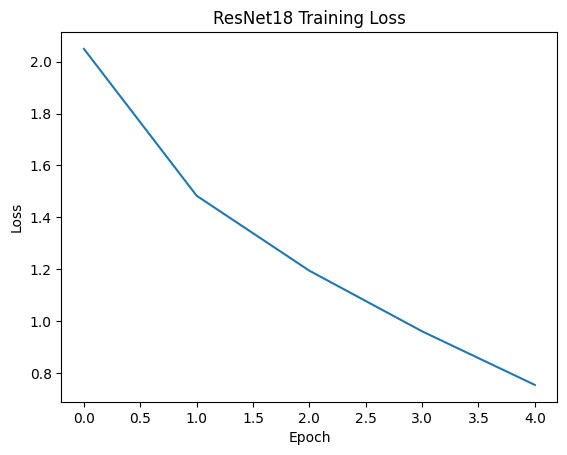

In [ ]:
plt.plot(losses_resnet)
plt.title('ResNet18 Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

Обучим модель ViT-B/16

In [ ]:
optimizer_vit = torch.optim.Adam(model_vit.parameters(), lr=1e-4)
losses_vit = train_model(model_vit, criterion, optimizer_vit, num_epochs=5)

100%|██████████| 218/218 [04:18<00:00,  1.18s/it]


Epoch 1/5, Loss: 1.2733


100%|██████████| 218/218 [04:17<00:00,  1.18s/it]


Epoch 2/5, Loss: 0.6551


100%|██████████| 218/218 [04:17<00:00,  1.18s/it]


Epoch 3/5, Loss: 0.4567


100%|██████████| 218/218 [04:17<00:00,  1.18s/it]


Epoch 4/5, Loss: 0.3361


100%|██████████| 218/218 [04:16<00:00,  1.18s/it]

Epoch 5/5, Loss: 0.2533


Фунция оценки обученной модели. В качестве метрик будем использовать Accuracy и F1, которые хорошо подходят для выбранных данных ввиду их равномерного распределения по классам

In [ ]:
def evaluate_model(model):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='macro')
    cm = confusion_matrix(all_labels, all_preds)

    return accuracy, f1, cm

Метрики модели ResNet-18:

In [ ]:
acc_resnet, f1_resnet, cm_resnet = evaluate_model(model_resnet)
print(f'ResNet18 Accuracy: {acc_resnet:.3f}, F1: {f1_resnet:.3f}')

ResNet18 Accuracy: 0.583, F1: 0.574


Confusion Matrix для модели ResNet-18:

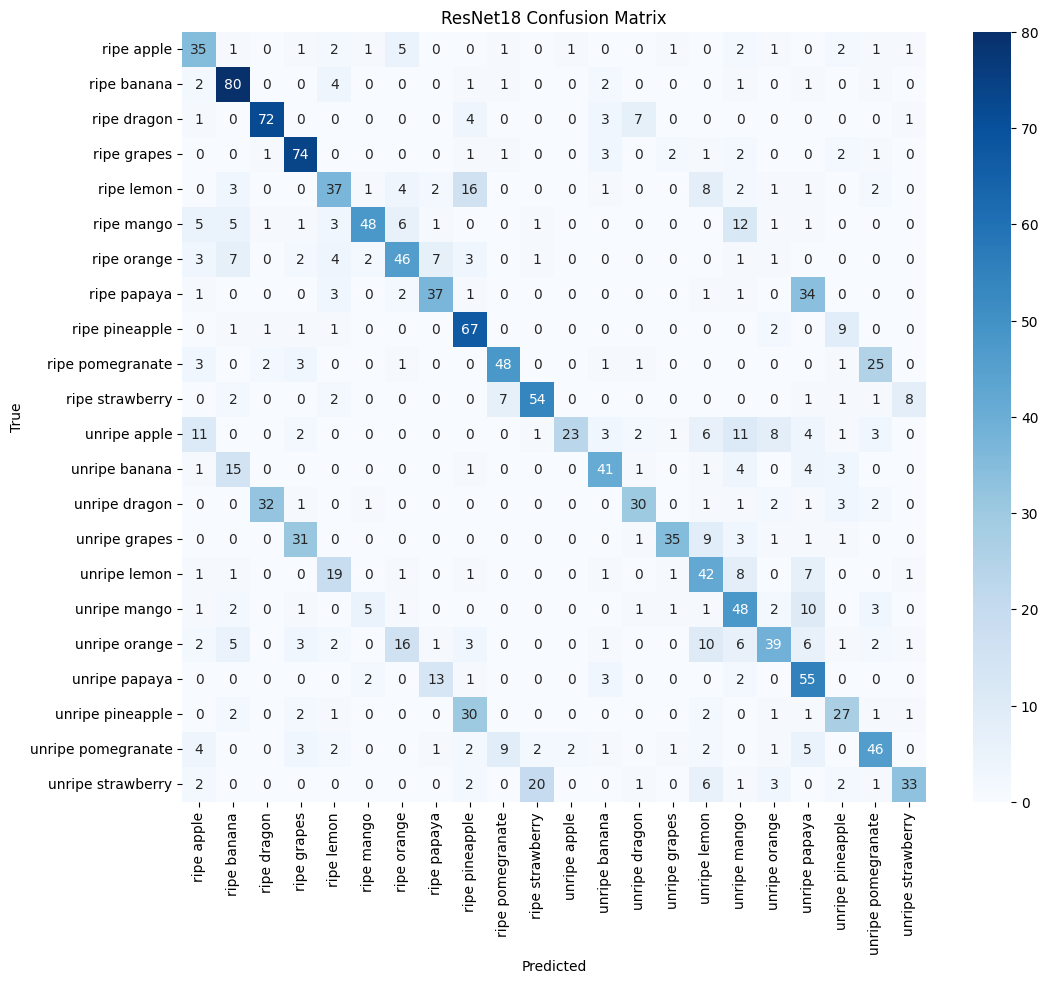

In [ ]:
plt.figure(figsize=(12,10))
sns.heatmap(cm_resnet, annot=True, fmt='d', cmap='Blues', xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.title('ResNet18 Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Метрики для модели ViT:

In [ ]:
acc_vit, f1_vit, cm_vit = evaluate_model(model_vit)
print(f'ResNet18 Accuracy: {acc_vit:.3f}, F1: {f1_vit:.3f}')

ResNet18 Accuracy: 0.708, F1: 0.706


Confusion Matrix для ViT:

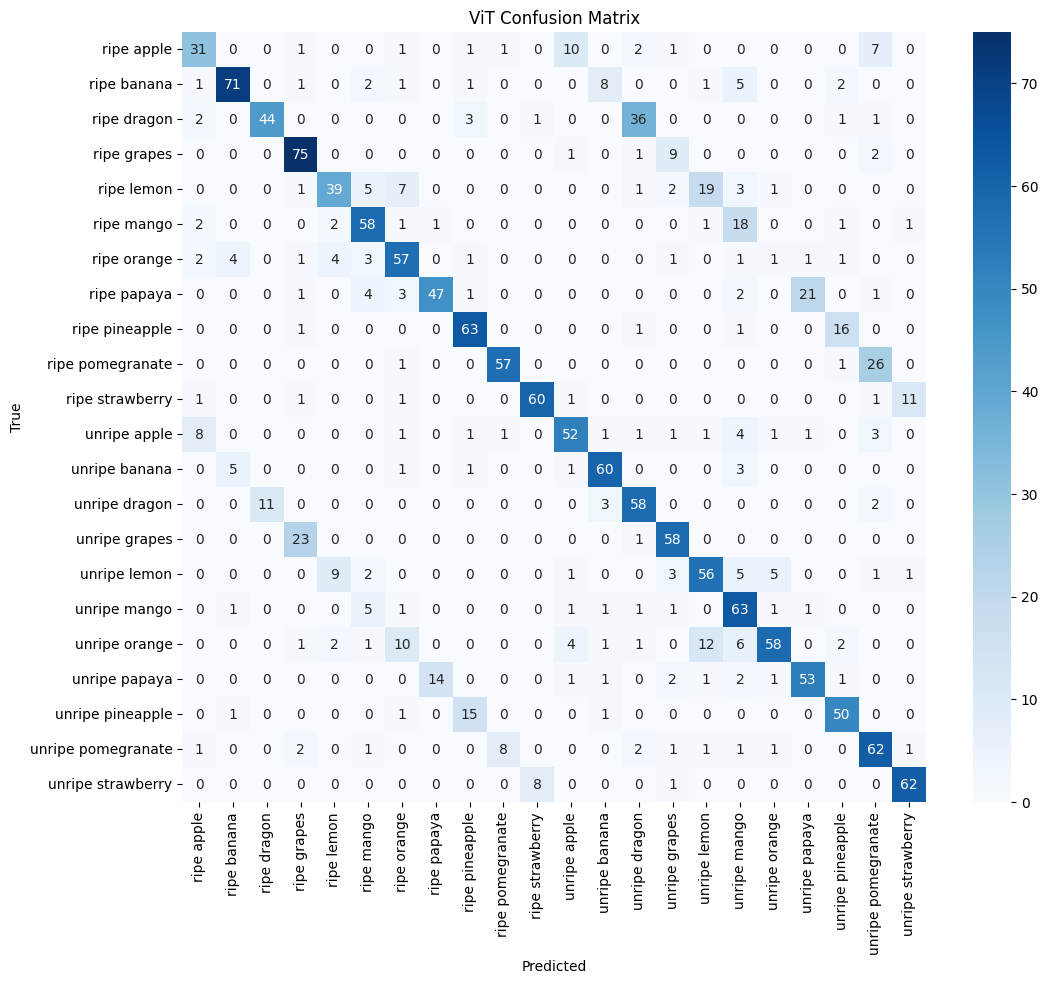

In [ ]:
plt.figure(figsize=(12,10))
sns.heatmap(cm_vit, annot=True, fmt='d', cmap='Blues', xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.title('ViT Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

По матрицам видно, что чаще всего модели ошибаются на одинаковых фруктах, но разной зрелости (что логично), кроме этого можно увидеть, что ошибок в определении самого фрукта достаточно мало

## 3.	Улучшение бейзлайна

Для улучшения бейзлайна добавим аугментации (случайный цветовой шум, вращение, отражение), а также будем использовать более подходящие оптимизаторы; также можно заменить модель на более точную (resNet-18 на ResNet-50) и увеличить количество эпох

In [ ]:
augmented_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset.dataset.transform = augmented_transform

model_resnet50 = models.resnet50(pretrained=True)
model_resnet50.fc = torch.nn.Linear(model_resnet50.fc.in_features, len(dataset.classes))
model_resnet50 = model_resnet50.to(device)

model_vit_improved = models.vit_b_16(pretrained=True)
model_vit_improved.heads.head = torch.nn.Linear(model_vit.heads.head.in_features, len(dataset.classes))
model_vit_improved = model_vit_improved.to(device)

Обучим модель ResNet-50 на улучшенном бейзлайне

In [ ]:
optimizer_resnet50 = torch.optim.AdamW(model_resnet50.parameters(), lr=1e-4)
losses_resnet50 = train_model(model_resnet50, criterion, optimizer_resnet50, num_epochs=5)

100%|██████████| 218/218 [01:28<00:00,  2.46it/s]


Epoch 1/5, Loss: 0.9132


100%|██████████| 218/218 [01:28<00:00,  2.46it/s]


Epoch 2/5, Loss: 0.7497


100%|██████████| 218/218 [01:28<00:00,  2.46it/s]


Epoch 3/5, Loss: 0.6548


100%|██████████| 218/218 [01:28<00:00,  2.47it/s]


Epoch 4/5, Loss: 0.5654


100%|██████████| 218/218 [01:28<00:00,  2.46it/s]

Epoch 5/5, Loss: 0.4957


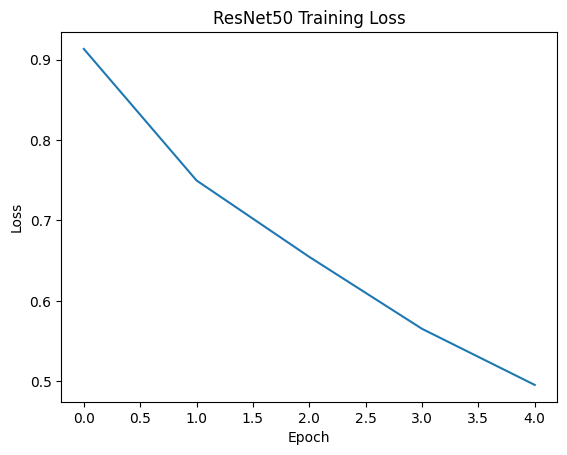

In [ ]:
plt.plot(losses_resnet50)
plt.title('ResNet50 Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

Точность модели ResNet-50

In [ ]:
acc_resnet50, f1_resnet50, cm_resnet50 = evaluate_model(model_resnet50)
print(f'ResNet50 Accuracy: {acc_resnet50:.3f}, F1: {f1_resnet50:.3f}')

ResNet50 Accuracy: 0.691, F1: 0.683


Обучим модель ViT на улучшенном бейзлайне

In [ ]:
optimizer_vit_improved = torch.optim.AdamW(model_vit_improved.parameters(), lr=1e-4)
losses_vit_improved = train_model(model_vit_improved, criterion, optimizer_vit_improved, num_epochs=5)

100%|██████████| 218/218 [04:13<00:00,  1.16s/it]


Epoch 1/5, Loss: 1.4002


100%|██████████| 218/218 [04:23<00:00,  1.21s/it]


Epoch 2/5, Loss: 0.8453


100%|██████████| 218/218 [04:23<00:00,  1.21s/it]


Epoch 3/5, Loss: 0.6384


100%|██████████| 218/218 [04:24<00:00,  1.21s/it]


Epoch 4/5, Loss: 0.5141


100%|██████████| 218/218 [04:23<00:00,  1.21s/it]

Epoch 5/5, Loss: 0.4318


Точность возросла не так сильно, поэтому запустим еще 5 эпох

In [ ]:
losses_vit_improved_2 = train_model(model_vit_improved, criterion, optimizer_vit_improved, num_epochs=5)

100%|██████████| 218/218 [04:23<00:00,  1.21s/it]


Epoch 1/5, Loss: 0.3542


100%|██████████| 218/218 [04:24<00:00,  1.21s/it]


Epoch 2/5, Loss: 0.3017


100%|██████████| 218/218 [04:25<00:00,  1.22s/it]


Epoch 3/5, Loss: 0.2729


100%|██████████| 218/218 [04:23<00:00,  1.21s/it]


Epoch 4/5, Loss: 0.2777


100%|██████████| 218/218 [04:23<00:00,  1.21s/it]

Epoch 5/5, Loss: 0.2253


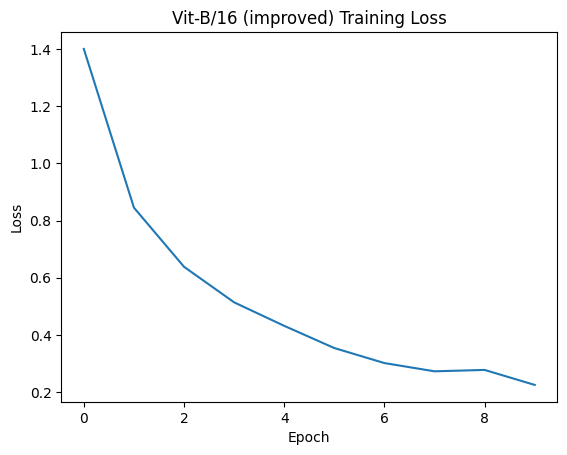

In [ ]:
plt.plot(losses_vit_improved + losses_vit_improved_2)
plt.title('Vit-B/16 (improved) Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

Метрики ViT на улучшенном бейзлайне

In [ ]:
acc_vit_improved, f1_vit_improved, cm_vit_improved = evaluate_model(model_vit_improved)
print(f'Vit (Improved) Accuracy: {acc_vit_improved:.3f}, F1: {f1_vit_improved:.3f}')

Vit (Improved) Accuracy: 0.711, F1: 0.707


## 4.	Имплементация алгоритма машинного обучения 

Реализуем свой класс для свёрточной модели:

In [ ]:
class CustomCNN(torch.nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.features = torch.nn.Sequential(
            torch.nn.Conv2d(3, 32, 3, padding=1),
            torch.nn.BatchNorm2d(32),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2),
            torch.nn.Conv2d(32, 64, 3, padding=1),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2),
            torch.nn.Conv2d(64, 128, 3, padding=1),
            torch.nn.BatchNorm2d(128),
            torch.nn.ReLU(),
            torch.nn.AdaptiveAvgPool2d((4,4))
        )
        self.classifier = torch.nn.Sequential(
            torch.nn.Linear(128*4*4, 512),
            torch.nn.Dropout(0.3),
            torch.nn.ReLU(),
            torch.nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)

model_custom = CustomCNN(len(dataset.classes)).to(device)
optimizer_custom = torch.optim.Adam(model_custom.parameters(), lr=1e-3)
losses_custom = train_model(model_custom, criterion, optimizer_custom)

acc_custom, f1_custom, cm_custom = evaluate_model(model_custom)
print(f'Custom CNN Accuracy: {acc_custom:.3f}')


100%|██████████| 218/218 [00:38<00:00,  5.68it/s]


Epoch 1/5, Loss: 2.7147


100%|██████████| 218/218 [00:33<00:00,  6.55it/s]


Epoch 2/5, Loss: 2.5025


100%|██████████| 218/218 [00:33<00:00,  6.45it/s]


Epoch 3/5, Loss: 2.4200


100%|██████████| 218/218 [00:33<00:00,  6.58it/s]


Epoch 4/5, Loss: 2.3698


100%|██████████| 218/218 [00:38<00:00,  5.63it/s]


Epoch 5/5, Loss: 2.3250
Custom CNN Accuracy: 0.273


Обучим модель с более подходящим оптимизатором и на большем числе эпох

In [ ]:
model_custom = CustomCNN(len(dataset.classes)).to(device)
optimizer_custom = torch.optim.SGD(model_custom.parameters(), lr=1e-3, momentum=0.9)
losses_custom = train_model(model_custom, criterion, optimizer_custom, num_epochs=15)

acc_custom, f1_custom, cm_custom = evaluate_model(model_custom)
print(f'Custom CNN Accuracy: {acc_custom:.3f}')

100%|██████████| 218/218 [00:33<00:00,  6.56it/s]


Epoch 1/15, Loss: 2.8902


100%|██████████| 218/218 [00:34<00:00,  6.36it/s]


Epoch 2/15, Loss: 2.6126


100%|██████████| 218/218 [00:32<00:00,  6.64it/s]


Epoch 3/15, Loss: 2.5059


100%|██████████| 218/218 [00:33<00:00,  6.59it/s]


Epoch 4/15, Loss: 2.4503


100%|██████████| 218/218 [00:34<00:00,  6.32it/s]


Epoch 5/15, Loss: 2.3947


100%|██████████| 218/218 [00:33<00:00,  6.53it/s]


Epoch 6/15, Loss: 2.3574


100%|██████████| 218/218 [00:33<00:00,  6.58it/s]


Epoch 7/15, Loss: 2.3166


100%|██████████| 218/218 [00:33<00:00,  6.53it/s]


Epoch 8/15, Loss: 2.2818


100%|██████████| 218/218 [00:33<00:00,  6.53it/s]


Epoch 9/15, Loss: 2.2645


100%|██████████| 218/218 [00:34<00:00,  6.40it/s]


Epoch 10/15, Loss: 2.2442


100%|██████████| 218/218 [00:33<00:00,  6.50it/s]


Epoch 11/15, Loss: 2.2043


100%|██████████| 218/218 [00:33<00:00,  6.45it/s]


Epoch 12/15, Loss: 2.1836


100%|██████████| 218/218 [00:33<00:00,  6.46it/s]


Epoch 13/15, Loss: 2.1621


100%|██████████| 218/218 [00:33<00:00,  6.50it/s]


Epoch 14/15, Loss: 2.1588


100%|██████████| 218/218 [00:33<00:00,  6.59it/s]


Epoch 15/15, Loss: 2.1265
Custom CNN Accuracy: 0.328


Собственная реализация модели ViT:

In [ ]:
class CustomViT(torch.nn.Module):
    def __init__(self, num_classes, image_size=100, patch_size=25):
        super().__init__()
        num_patches = (image_size//patch_size)**2
        self.patch_embed = torch.nn.Conv2d(3, 128, kernel_size=patch_size, stride=patch_size)
        self.transformer = torch.nn.TransformerEncoderLayer(
            d_model=128, nhead=4, dim_feedforward=512)
        self.classifier = torch.nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.patch_embed(x).flatten(2).permute(2,0,1)
        x = self.transformer(x)
        return self.classifier(x.mean(dim=0))

Обучение модели:

In [ ]:
custom_vit = CustomViT(len(dataset.classes)).to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(custom_vit.parameters(), lr=0.0005)

losses_custom = train_model(custom_vit, criterion, optimizer, num_epochs=15)
acc_custom, f1_custom, cm_custom = evaluate_model(custom_vit)
print(f'Custom ViT Accuracy: {acc_custom:.3f}')

100%|██████████| 218/218 [00:15<00:00, 14.09it/s]


Epoch 1/15, Loss: 2.7640


100%|██████████| 218/218 [00:15<00:00, 13.97it/s]


Epoch 2/15, Loss: 2.5436


100%|██████████| 218/218 [00:16<00:00, 13.51it/s]


Epoch 3/15, Loss: 2.4658


100%|██████████| 218/218 [00:15<00:00, 13.97it/s]


Epoch 4/15, Loss: 2.4122


100%|██████████| 218/218 [00:15<00:00, 14.18it/s]


Epoch 5/15, Loss: 2.3732


100%|██████████| 218/218 [00:16<00:00, 13.58it/s]


Epoch 6/15, Loss: 2.3724


100%|██████████| 218/218 [00:15<00:00, 14.09it/s]


Epoch 7/15, Loss: 2.3560


100%|██████████| 218/218 [00:15<00:00, 14.12it/s]


Epoch 8/15, Loss: 2.3154


100%|██████████| 218/218 [00:15<00:00, 14.17it/s]


Epoch 9/15, Loss: 2.3041


100%|██████████| 218/218 [00:16<00:00, 13.57it/s]


Epoch 10/15, Loss: 2.3058


100%|██████████| 218/218 [00:15<00:00, 14.17it/s]


Epoch 11/15, Loss: 2.3084


100%|██████████| 218/218 [00:15<00:00, 14.01it/s]


Epoch 12/15, Loss: 2.2880


100%|██████████| 218/218 [00:15<00:00, 13.87it/s]


Epoch 13/15, Loss: 2.3018


100%|██████████| 218/218 [00:15<00:00, 13.73it/s]


Epoch 14/15, Loss: 2.3007


100%|██████████| 218/218 [00:15<00:00, 13.87it/s]


Epoch 15/15, Loss: 2.3394
Custom ViT Accuracy: 0.255


## Вывод

В ходе выполнения работы были обучены библиотечные модели (свёрточная и трансформерная) для задачи классификации на обычном и улучшенном бейзлайне, а также реализованы собственные модели; их точность оказалась низкой, что может свидетельствовать об ошибках в имплементации или особенности датасета: один фрукт по сути разделён на два класса, что существенно усложняет классификацию (даже библиотечные решения еле смогли перейти черту в 0.7).

Результаты моделей:

| Модель   | Accuracy |
|----------|----------|
| ResNet-18 |   0.583  |
| ViT-B/16 |   0.708  |
| ResNet-50 (улучшенный бейзлайн) |  0.691  |
| ViT-B/16 (улучшенный бейзлайн) |  0.711  |
| CustomCNN |  0.328  |
| CustomViT |  0.255  |

